In [1]:
# !pip install scikit-learn

In [21]:
import pandas as pd
import tensorflow as tf
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

In [24]:
df_train_original = pd.read_csv('data/application_train.csv')
df_test_original = pd.read_csv('data/application_test.csv')

### Perform a preprocessing step on the train data

In [25]:
# Drop columns with all NaN values
df_train_original = df_train_original.dropna(axis=1, how='all')

# Drop columns with more than 95% NaN values
threshold = len(df_train_original) * 0.95
df_train_original = df_train_original.dropna(axis=1, thresh=threshold)

# Drop NaN values
df_train_original = df_train_original.dropna()

# One-hot encode categorical variables
df_train_original = pd.get_dummies(df_train_original)

### Perform a preprocessing step on the test data

In [26]:
# Drop columns with all NaN values
df_test_original = df_test_original.dropna(axis=1, how='all')

# Drop columns with more than 95% NaN values
threshold = len(df_test_original) * 0.95
df_test_original = df_test_original.dropna(axis=1, thresh=threshold)

# Drop NaN values
df_test_original = df_test_original.dropna()

# One-hot encode categorical variables
df_test_original = pd.get_dummies(df_test_original)

### Remove columns from `df_train_original` that do not exist in `df_test_original`

In [27]:
intersection = list(set(df_train_original.columns) &
                  set(df_test_original.columns))
intersection.append("TARGET")

df_train_original = df_train_original[intersection]

In [28]:
# Separate features and target variable from df_train
X = df_train_original
y = df_train_original['TARGET']

In [29]:
# Define the SMOTE sampler
smote = SMOTE(sampling_strategy=0.5, k_neighbors=10,
              random_state=42, n_jobs=-1)

# Display the number of samples before SMOTE
print("Number of samples before SMOTE:")
print("X_train_scaled:", X.shape[0])
print("y_train:", y.shape[0])

# Apply SMOTE
X_train_balanced, y_train_balanced = smote.fit_resample(X, y)

# Display the number of samples after SMOTE
print("\nNumber of samples after SMOTE:")
print("X_train_balanced:", X_train_balanced.shape[0])
print("y_train_balanced:", y_train_balanced.shape[0])

Number of samples before SMOTE:
X_train_scaled: 304531
y_train: 304531


c:\Work\Home Credit Default Risk\.venv\lib\site-packages\imblearn\over_sampling\_smote\base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(



Number of samples after SMOTE:
X_train_balanced: 419796
y_train_balanced: 419796


In [31]:
X_train_balanced = X_train_balanced.drop(columns=['TARGET', 'SK_ID_CURR'])

In [32]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_balanced, y_train_balanced, test_size=0.2, random_state=42)

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Transform the validation and test data
X_val_scaled = scaler.transform(X_val)

# Ensure df_test has the same columns as X_train
df_test_aligned = df_test_original[X_train.columns]

# Transform the test data
X_test_scaled = scaler.transform(df_test_aligned)

In [33]:
len(X_train_scaled), len(X_train_balanced)

(335836, 419796)

In [34]:
# Configure the RandomForest model
rf_model = RandomForestClassifier(
    n_estimators=100,  # Number of trees in the forest
    max_depth=None,    # Maximum depth of the tree
    min_samples_split=2,  # Minimum number of samples required to split an internal node
    min_samples_leaf=1,   # Minimum number of samples required to be at a leaf node
    max_features='sqrt',  # Number of features to consider when looking for the best split
    random_state=42,      # Seed for reproducibility
    n_jobs=-1             # Use all available cores
)

In [35]:
# Train the model
rf_model.fit(X_train_balanced, y_train_balanced)

# Predict on the validation set
y_pred = rf_model.predict(X_val_scaled)

c:\Work\Home Credit Default Risk\.venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [36]:
# Get predicted probabilities for the positive class
y_pred_proba = rf_model.predict_proba(X_val_scaled)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

# Calculate the ROC AUC score
roc_score = roc_auc_score(y_val, y_pred_proba)

# Display the ROC AUC score
print("ROC AUC Score:", roc_score)

c:\Work\Home Credit Default Risk\.venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


ROC AUC Score: 0.9110885305916981


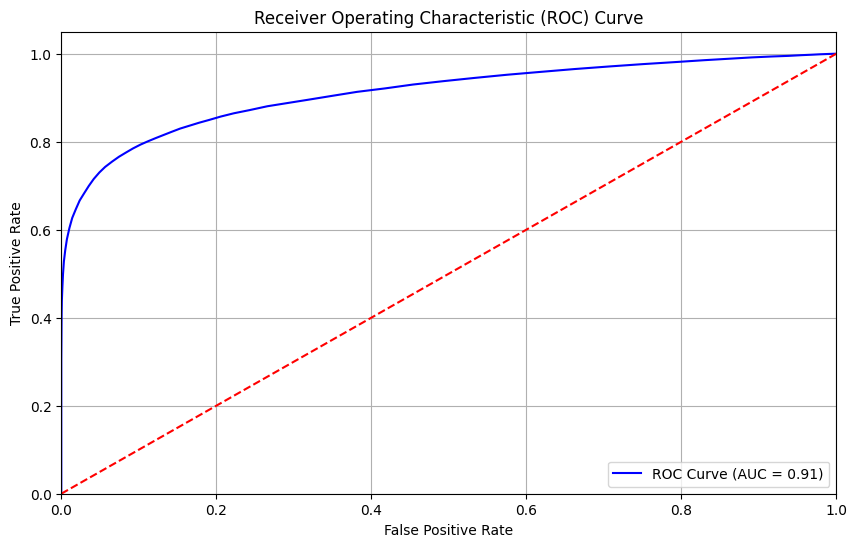

In [37]:
# Plotting the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label='ROC Curve (AUC = {:.2f})'.format(roc_score))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [38]:
# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred)
class_report = classification_report(y_val, y_pred)

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)

Accuracy: 0.8226893758932825
Confusion Matrix:
[[45250 10666]
 [ 4221 23823]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.81      0.86     55916
           1       0.69      0.85      0.76     28044

    accuracy                           0.82     83960
   macro avg       0.80      0.83      0.81     83960
weighted avg       0.84      0.82      0.83     83960



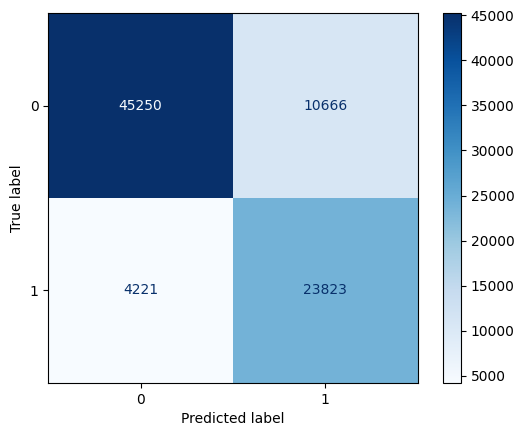

In [39]:
# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [40]:
# Predict on the test set
df_test_original['TARGET'] = rf_model.predict(
    X_test_scaled).round().astype(int)

# Export the predictions to a CSV file
df_test_original.to_csv('df_test_original_predictions_random_forest.csv', index=False)

c:\Work\Home Credit Default Risk\.venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
